## Partial Least Squares Regression
Machine learning often involves very high dimensional data, where the number of features is larger than the number of samples. In this case, using methods like PCA or partial least squares (PLS) can be useful for feature reduction. In the other tutorial I explored using PCA to reduce a dataset with 600 features to a smaller one with 6. In PC regression, feature selection ignores the outcome variable and all features are retained (be it at some weighting). In PLS the outcome variable is included in the regression and only features with the highest association to the outcome are retained. In PLS the regression model is generated using individual features against the outcome variable to determine a level of association between the outcome and each of the individual features from the subset (as represented by the coefficient associated with each input variable) . This is then used to select features that are most highly associated with the outcome for modelling (i.e. those that have large absolute coefficients).

The main difference between PCA and PLS is that PCA finds components that explain **variance** in the input data (X), while PLS finds components that maximise the **covariance** between X and Y (the output variable). 

Below I will work through [this tutorial](https://nirpyresearch.com/variable-selection-method-pls-python/) to explore using PLS in the same dataset as used in the [PC regression exercise](https://github.com/PlantsGenesBugs/PCA_PLS_feature_selection/blob/main/Principal_Component_Regression.ipynb). 

If you want a good explanation of PLS, I can recommend this [short video](https://youtu.be/Vf7doatc2rA).

In [2]:
# import required packages

# for outputting messages to the terminal
from sys import stdout

# for working with datasets, dataframes, numbers and graphs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for signal processing
from scipy.signal import savgol_filter

# scikitlearn used for data analysis and ML
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Load data; data is available from here: https://github.com/nevernervous78/nirpyresearch/tree/master 
data = pd.read_csv('./data/peach_spectra_brix.csv')

# check head (top 5 lines)
data.head()

,Brix,wl1,wl2,wl3,wl4,wl5,wl6,wl7,wl8,wl9,...,wl591,wl592,wl593,wl594,wl595,wl596,wl597,wl598,wl599,wl600
0,15.5,-1.032355,-1.030551,-1.027970,-1.024937,-1.021866,-1.019143,-1.016866,-1.014910,-1.012907,...,0.692447,0.692944,0.692376,0.690764,0.688081,0.684294,0.679348,0.673240,0.665922,0.657307
1,16.7,-1.139034,-1.137186,-1.134485,-1.131222,-1.127761,-1.124464,-1.121508,-1.118802,-1.115973,...,0.729328,0.728031,0.725548,0.721815,0.716767,0.710405,0.702706,0.693710,0.683480,0.671960
2,18.1,-1.152821,-1.150937,-1.148288,-1.145165,-1.141951,-1.138977,-1.136366,-1.134011,-1.131516,...,0.736608,0.735214,0.732669,0.728911,0.723844,0.717415,0.709645,0.700555,0.690147,0.678390
3,14.8,-1.087215,-1.085455,-1.082867,-1.079797,-1.076568,-1.073632,-1.071087,-1.068877,-1.066654,...,0.758695,0.757963,0.756038,0.752903,0.748496,0.742886,0.736085,0.728019,0.718577,0.707702
4,15.1,-1.080364,-1.078436,-1.075784,-1.072693,-1.069562,-1.066691,-1.064214,-1.062025,-1.059787,...,0.719793,0.718875,0.716860,0.713771,0.709577,0.704232,0.697717,0.689882,0.680748,0.670263


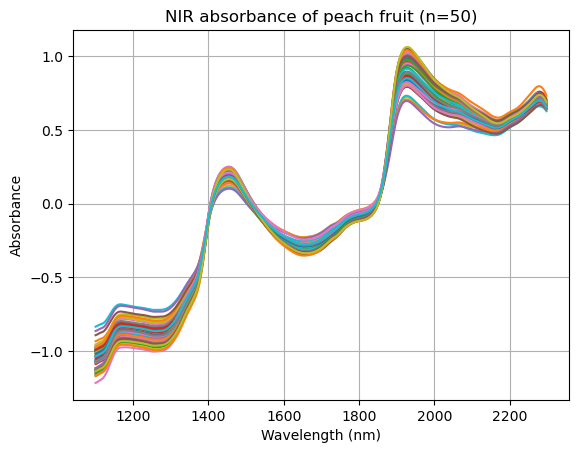

In [4]:
# separate output variable ('Brix') from all input variables (absorbance values)
y = data['Brix']

# convert dataframe into Numpy array; select all rows, select columns from the second one to the end
X = data.values[:,1:]
 
# define wavelength range; 600 wavelengths between 1100 and 2299)
wl = np.arange(1100,2300,2)
 
# plot absorbance spectra
plt.plot(wl, X.T)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.title("NIR absorbance of peach fruit (n=50)")
plt.grid(True)
plt.show()

In [5]:
## calculate derivatives
# derivatives are used in spectroscopic data analysis to enhance spectral resolution and improve model performance

# include 11 points in the smoothing window; fit a 2nd-degree polynomial in each window; return 1st derivative 
X1 = savgol_filter(X, 11, polyorder = 2, deriv=1) # remove baseline and enhance peaks

# include 13 points in the smoothing window; fit a 2nd-degree polynomial in each window; return 2nd derivative
X2 = savgol_filter(X, 13, polyorder = 2,deriv=2) # highlight curvature and peak sharpness

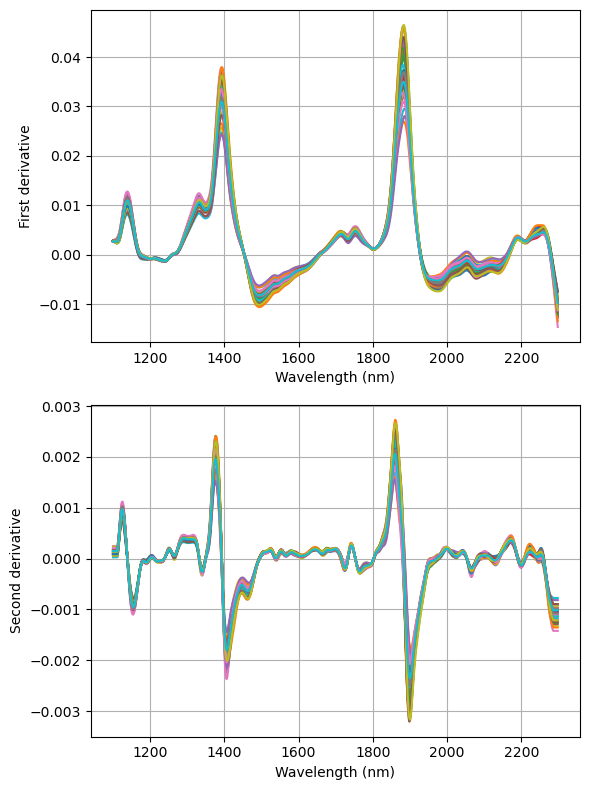

In [6]:
# plot derived signal to show change from original spectrum
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

# plot X1
ax1.plot(wl, X1.T)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('First derivative')
ax1.grid(True)

# plot X2
ax2.plot(wl, X2.T)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Second derivative')
ax2.grid(True)

# adjust layout
plt.tight_layout()
plt.show()

PLS combines features into latent variables, optimising the weights of the features to express variance and represent the 'importance' of that feature. The weight values are chosen so that they optimise the covariance between the created latent variable and the outcome variable. When there are many features the number of components can be varied and the number of components with the smallest mean square error (MSE) can be selected.

anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


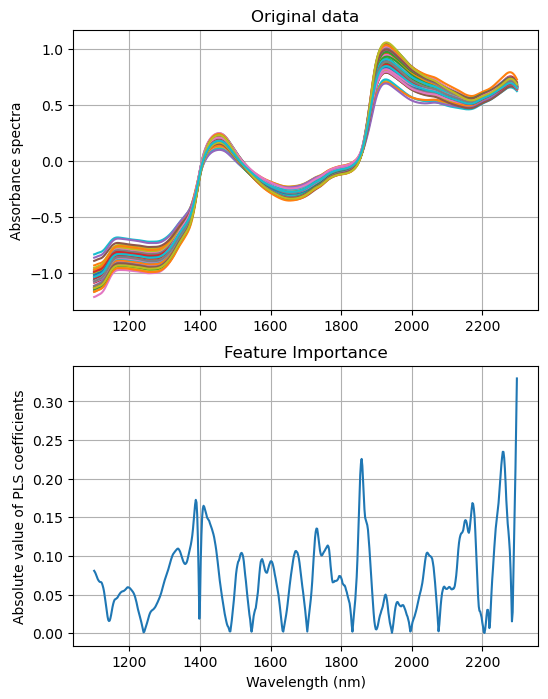

In [8]:
# apply PLS to untransformed data first

# create a Partial Least Squares model using 8 latent variables
pls = PLSRegression(n_components=8)

# fit data
pls.fit(X, y)
 
# plot spectra
plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
plt.plot(wl, X.T)
plt.ylabel('Absorbance spectra')
plt.title('Original data')
plt.grid(True)
 
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(wl, np.abs(pls.coef_[:,0]))  # regression coefficients from the fitted PLS model
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absolute value of PLS coefficients')
plt.title('Feature Importance')
plt.grid(True)
plt.show()

Most features have a similar "weight" when using raw data, with pronounced peaks at around 1850 nm and above 2200 nm. Derivatising before modelling should enhance the signal-to-noise ratio, reduce spectral overlap, and improve the interpretability of the data ([Rinnan et al, 2009](https://www.sciencedirect.com/science/article/pii/S0165993609001629)). Below I will compare the output from PLS of raw data to PLS using the first and second derivative. 


In [10]:
# Generalised function to automate PLS modeling and graphing

def plot_spectra_vs_pls_coefficients(X, wl, num_comp, title):
    
    # create a Partial Least Squares model
    pls = PLSRegression(n_components=num_comp)
    
    # fit data
    pls.fit(X, y)
    
    # plot spectra
    plt.figure(figsize=(6,8))
    ax1 = plt.subplot(211)
    plt.plot(wl, X.T)
    plt.ylabel('Absorbance spectra')
    plt.title(title)
    plt.grid(True)

    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_[:,0]))  # regression coefficients from the fitted PLS model
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')
    plt.title('Feature Importance')
    plt.grid(True)
    plt.show()
    

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


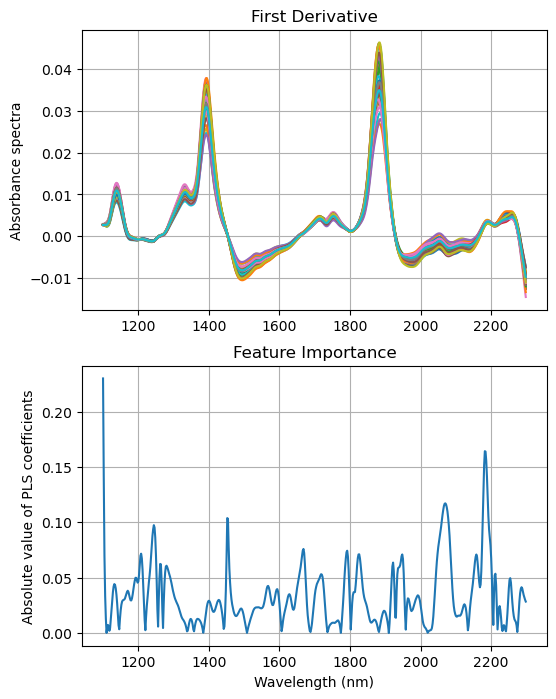

In [11]:
# plot first derivative
plot_spectra_vs_pls_coefficients(X1, wl, 8, 'First Derivative')

The overall weighting has decreased i.e. in the previous graph, most of the coefficients had absolute values at 0.1 or above whereas here the values are much smaller. There are, again, a few pronounced peaks, namely at around 1300 nm, 1450 nm, 2050 nm and 2180 nm.

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


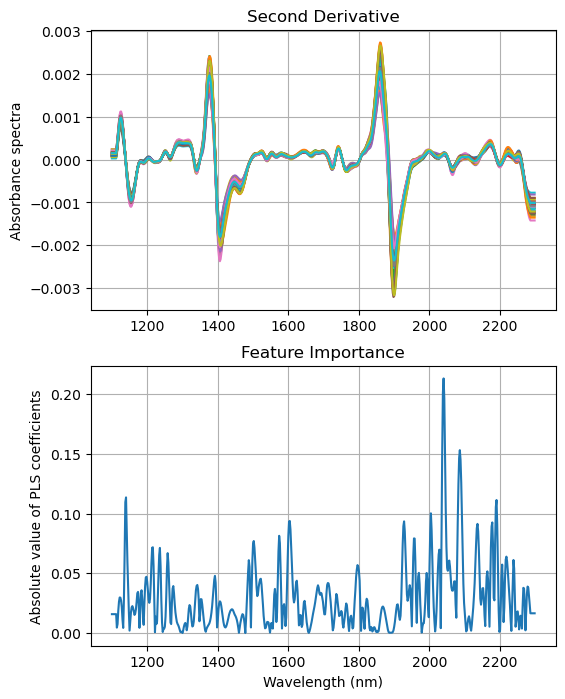

In [13]:
# plot second derivative
plot_spectra_vs_pls_coefficients(X2, wl, 8, 'Second Derivative')

The absolute values of peaks have decreased again, but there are more pronounced peaks available and two large peaks between 2000 and 2200 nm.

### Feature Selection  
From here on we want to discard peaks with small absolute coefficients, test the predictive ability of the model after each removal, and stop at the point where the mean squared error (MSE) starts increasing again (we want the coefficients with the smallest MSE). In order to do this systematically we start with the smallest absolute coefficients. In order to do this, we sort the coefficients in decreasing order before automating the analysis. 

In [15]:
# get the list of indices that sorts the PLS coefficients in ascending order of the absolute value
sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
 
# sort spectra according to ascending absolute value of PLS coefficients
Xc = X1[:,sorted_ind]

Below is the optimisation function as presented in the tutorial. It repeatedly runs a PLS regression using different numbers of components. For each regression it sorts the coefficients, and spectra, in ascending size. Then it discards wavelengths one at a time from the spectra and repeats the PLS regression, taking performance metrics for each iteration. Once it has looped through all of the wavelengths, it calculates and prints the best number of components to use and the optimised MSE. It then automatically uses this value in PLS regression using the original data.

In [17]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
 
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
 
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
 
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
 
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
 
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
 
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
 
    Xc = X[:,sorted_ind]
 
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [18]:
# use the above function with max comp at 8 and raw data
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X,y,8)

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


12% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


25% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


37% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


62% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


75% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


87% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed
Optimised number of PLS components:  6
Wavelengths to be discarded  453
Optimised MSEP  2.5410889448066705



/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


This takes quite some time, and triggers a fair number of warnings with regards to the `coef_` attribute. Nevertheless, we see that the optimal number of PLS components is 6, as determined by PC regression in the previous exercise. 

In [20]:
# repeat for first and second derivatives

# first derivative; 15 max components
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X1,y,15)

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


6% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


13% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


20% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


26% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


33% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


40% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


46% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


53% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


60% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


66% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


73% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


80% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


86% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


93% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed
Optimised number of PLS components:  10
Wavelengths to be discarded  417
Optimised MSEP  1.9073192879568055



/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


Optimal number of components for first derivative data is 10.

In [21]:
# second derivative; 20 max components
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X2,y,20)

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


15% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


20% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


25% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


30% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


35% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


40% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


45% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


55% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


60% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


65% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


70% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


75% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


80% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


85% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


90% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


95% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed
Optimised number of PLS components:  20
Wavelengths to be discarded  439
Optimised MSEP  1.1842377115993536



/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


Optimal number of components for second derivative data is 20.

In [22]:
def simple_pls_cv(X, y, n_comp):
 
    # Run PLS with suggested number of components
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X, y)
    y_c = pls.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)    
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression 
 
    z = np.polyfit(y, y_cv, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_cv, y, c='red', edgecolors='k')
        ax.plot(z[1]+z[0]*y, y, c='blue', linewidth=1)
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        
        plt.show()

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


20% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


30% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


40% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


60% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


70% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


80% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


90% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed
Optimised number of PLS components:  10
Wavelengths to be discarded  417
Optimised MSEP  1.9073192879568055

R2 calib: 0.850
R2 CV: 0.590
MSE calib: 0.698
MSE CV: 1.910


/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


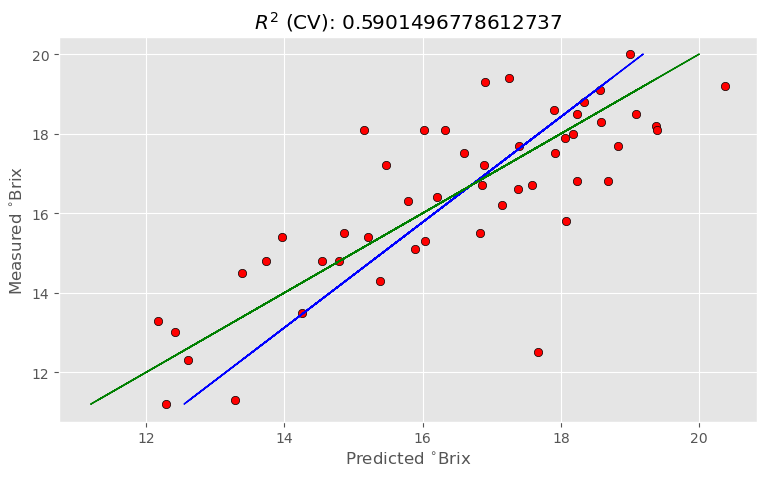

In [50]:
# Run final model with first and second derivative and optimal components

# first deriv
opt_Xc1, ncomp, wav, sorted_ind = pls_variable_selection(X1, y, 10)
simple_pls_cv(opt_Xc1, y, 10)

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


15% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


20% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


25% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


30% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


35% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


40% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


45% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


55% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


60% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


65% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


70% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


75% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


80% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


85% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


90% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


95% completed

/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed
Optimised number of PLS components:  20
Wavelengths to be discarded  439
Optimised MSEP  1.1842377115993536

R2 calib: 1.000
R2 CV: 0.810
MSE calib: 0.002
MSE CV: 0.887


/Users/anneke/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


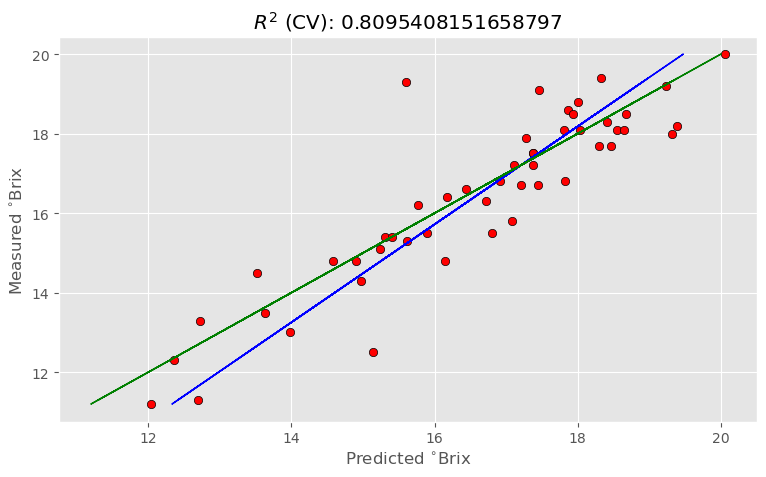

In [24]:
# second derivative; 20 max components
opt_Xc2, ncomp, wav, sorted_ind = pls_variable_selection(X2,y,20)
simple_pls_cv(opt_Xc2, y, 20)

Using the second derivative and 20 components returns the best performance of all models tested. The R<sup>2</sup> value is now 0.81, with an MSE of 0.887 This in comparison to the original MSE with raw data of 2.5 and MSE with first derivative data of 1.9. In addition, using the second derivative data leads to the removal of fewer wavelengths (439) than in raw data (453), but more than when using first derivative data.  

### References
Rinnan, Å., Van Den Berg, F. and Engelsen, S.B., 2009. Review of the most common pre-processing techniques for near-infrared spectra. TrAC Trends in Analytical Chemistry, 28(10), pp.1201-1222.